In [ ]:

# !pip install python-igraph
# !pip install riskfolio-lib
# !pip install dcorr
# !pip install dtw-python
# !pip install QuantStats

In [1]:
import matplotlib.pyplot as plt
import pandas as pd

from data_preparer import DataPreparer
from allocator import Allocator
import pickle

import numpy as np
from tqdm import tqdm
import copy

import quantstats as qs
from igraph import Graph

Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



In [2]:
with open("calculated_data/historical_ts_sim_dtw.pkl", "rb") as f:
    ts_sim = pickle.load(f)

In [44]:
preparer = DataPreparer()
# preparer.calculate_historical_ts_similarities(start_date="2023-01-01", end_date="2024-04-11", ts_similarity_metric="pearson")
preparer.ts_similarities = ts_sim

In [5]:
preparer.stockData.head()

,AAL,AAPL,ABBV,ABNB,ABT,ADBE,ADI,ADM,AEP,AES,...,VZ,WBA,WDC,WFC,WMB,WMT,WY,WYNN,XEL,XOM
Date,,,,,,,,,,,,,,,,,,,,,
2021-06-01,24.670000,122.357285,100.474297,144.309998,100.739174,495.910004,155.650543,63.800926,76.791321,23.600290,...,47.095600,45.689991,75.550003,44.099163,22.809120,45.285706,33.449654,134.235580,63.839256,54.156796
2021-06-02,25.820000,123.125221,99.749008,151.000000,101.796173,495.769989,156.420761,63.800926,77.287613,23.195143,...,47.321140,46.546032,76.599998,43.679253,23.148415,45.186600,32.687855,133.285309,64.058128,54.586765
2021-06-03,24.930000,121.628738,100.474297,144.190002,103.986359,493.140015,154.110107,64.110931,77.567345,23.084644,...,47.596794,47.358837,76.779999,43.352669,23.428335,45.266525,31.557394,127.771759,64.277008,54.801739
2021-06-04,24.299999,123.942390,100.608597,150.729996,104.072052,504.500000,157.447739,64.599396,77.630524,22.983351,...,47.864094,47.428005,77.169998,43.819214,23.708252,45.346447,31.313906,126.861076,63.912228,55.043591
2021-06-07,24.250000,123.952240,101.190620,148.970001,104.748161,509.470001,156.401749,64.496078,77.305656,23.314844,...,47.780571,47.177254,76.129997,43.959194,23.945761,45.042751,31.044331,127.791557,63.948700,54.685287


In [45]:
preparer.prepare_snapshots(weight_combination={"ts":0.55, "tx":0.45}) # 55, 45
preparer.calculate_similarity_matrix(node_count=len(preparer.stockData.columns), snapshot_start_id=0, snapshot_end_id=5)
preparer.calculate_final_communes()
node_metrics = preparer.calculate_node_metrics()

In [46]:
pagerank_threshold, closeness_threshold = np.mean(node_metrics.pagerank.dropna())-0.5*np.std(node_metrics.pagerank.dropna()), np.median(node_metrics.centrality.dropna())
investment_universe = list(node_metrics.reset_index()[(node_metrics.pagerank > pagerank_threshold) & (node_metrics.centrality < closeness_threshold)].sort_values(by="centrality", ascending=True)["index"])

In [59]:
# investment_universe = list(node_metrics.reset_index()[node_metrics.pagerank >= 0].groupby("commune").idxmin()["index"])
# investment_universe = list(node_metrics.reset_index()[node_metrics.centrality > 0].sort_values(by="centrality", ascending=True)["index"][:30])

In [47]:
len(investment_universe)

80

In [19]:
start_date = "2023-05-26"

In [48]:
allocator = Allocator()
mean_variance_optim = allocator.mean_variance_optimization(preparer.stockData[(preparer.stockData.index < start_date)&(preparer.stockData.index >"2023-01-01")], 
                                                           min_weight=0.01, take_pct_change=True) 
mean_variance_return = allocator.calculate_cumulative_return(mean_variance_optim[mean_variance_optim.weights > 0], stockData=preparer.stockData, startDate=start_date)

selected_stocks = []
for selected_id in investment_universe:
    selected_stocks.append(preparer.id2stock(selected_id))
    
filtered_optim = allocator.mean_variance_optimization(preparer.stockData[(preparer.stockData.index < start_date) & (preparer.stockData.index > "2023-01-01")][selected_stocks], 
                                                           min_weight=0.01, take_pct_change=True) 
filtered_return = allocator.calculate_cumulative_return(filtered_optim[filtered_optim.weights > 0], stockData=preparer.stockData, startDate=start_date)

You must convert self.cov to a positive definite matrix


In [49]:
print(filtered_return[0])

0.49762075532547373


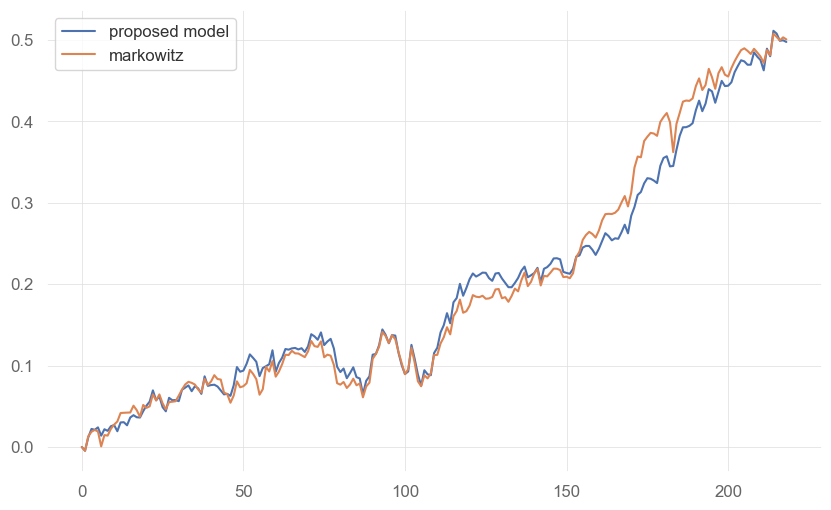

In [50]:
plt.plot(filtered_return[1], label="proposed model")
plt.plot(mean_variance_return[1], label="markowitz")

plt.legend()
plt.show()

In [41]:
def get_filtered_universe(preparer_obj, ts, tx, snapshot_start_id=0, snapshot_end_id=5):
    preparer_obj.prepare_snapshots(weight_combination={"ts":ts, "tx":tx})
    preparer_obj.calculate_similarity_matrix(node_count=200, snapshot_start_id=snapshot_start_id, snapshot_end_id=snapshot_end_id)
    preparer_obj.calculate_final_communes()
    node_metrics = preparer_obj.calculate_node_metrics()
    
    a, b = np.median(node_metrics.pagerank.dropna()) - np.std(node_metrics.pagerank.dropna())*0.5, np.median(node_metrics.centrality.dropna())
    investment_universe = list(node_metrics.reset_index()[(node_metrics.pagerank > a) & (node_metrics.centrality < b)].sort_values(by="centrality", ascending=True)["index"])
    # investment_universe = list(node_metrics.reset_index()[node_metrics.centrality > 0].groupby("commune").idxmin()["index"])
    # investment_universe = list(node_metrics.reset_index()[node_metrics.centrality > 0].sort_values(by="centrality", ascending=True)["index"][:30])

    selected_stocks = []
    for selected_id in investment_universe:
        selected_stocks.append(preparer_obj.id2stock(selected_id))
        
    return selected_stocks

In [ ]:
allocation_results = {
                      "euclidean": {"path": "calculated_data/historical_ts_sim.pkl"}, 
                      "pearson": {"path": "calculated_data/historical_ts_sim_pearson.pkl"},
                      "dist_corr": {"path": "calculated_data/historical_ts_sim_distCorr.pkl"},
                      "dtw": {"path": "calculated_data/historical_ts_sim_dtw.pkl"}
                      }

combinations = [{"id":0, "ts": 0.55, "tx": 0.45}, {"id":2, "ts": 0.0, "tx": 1.0}, {"id":3, "ts": 1.0, "tx": 0.0}]
 
for sim_metric in list(allocation_results.keys()):
    with open(allocation_results[sim_metric]["path"], "rb") as f:
        ts_sim = pickle.load(f)
    preparer.ts_similarities = ts_sim
    print("Sim metric: ", sim_metric)
    
    for combination_id, combination in enumerate(combinations):
        id, ts, tx = combination["id"], combination["ts"], combination["tx"]
        allocation_results[sim_metric][id] = []
        print("Combination ID: ", id, end=" ")
        
        for _ in tqdm(range(3)):
            selected_stocks = get_filtered_universe(preparer, ts, tx)
            print(len(selected_stocks))
            filtered_optim = allocator.mean_variance_optimization(
                preparer.stockData[(preparer.stockData.index < start_date) & 
                                   (preparer.stockData.index > "2023-01-01")][selected_stocks], min_weight=0.01, take_pct_change=True
            )
            filtered_return = allocator.calculate_cumulative_return(filtered_optim[filtered_optim.weights > 0], stockData=preparer.stockData, startDate=start_date)
            allocation_results[sim_metric][id].append(filtered_return[1])
            # print("Return:", filtered_return[1][-1])
            
            '''
            g = Graph.Weighted_Adjacency(preparer.sim_matrix.tolist(), mode="undirected")
            g.write_edgelist(f"saved_graphs/{sim_metric}/combination{combination_id}_edgelist.txt")
            '''

In [55]:
test_set = preparer.stockData[preparer.stockData.index>=start_date]
one_n_allocation = np.cumsum(np.sum(test_set.pct_change() * 100/len(test_set), axis=1))[1:] / 100

In [56]:
import datetime
import matplotlib.dates as mdates

invest_data = preparer.stockData[(preparer.stockData.index > start_date)]
data_index = np.array(invest_data.index)
data_index = [datetime.datetime.strptime(date, '%Y-%m-%d') for date in data_index]

one_n_allocation.index = data_index

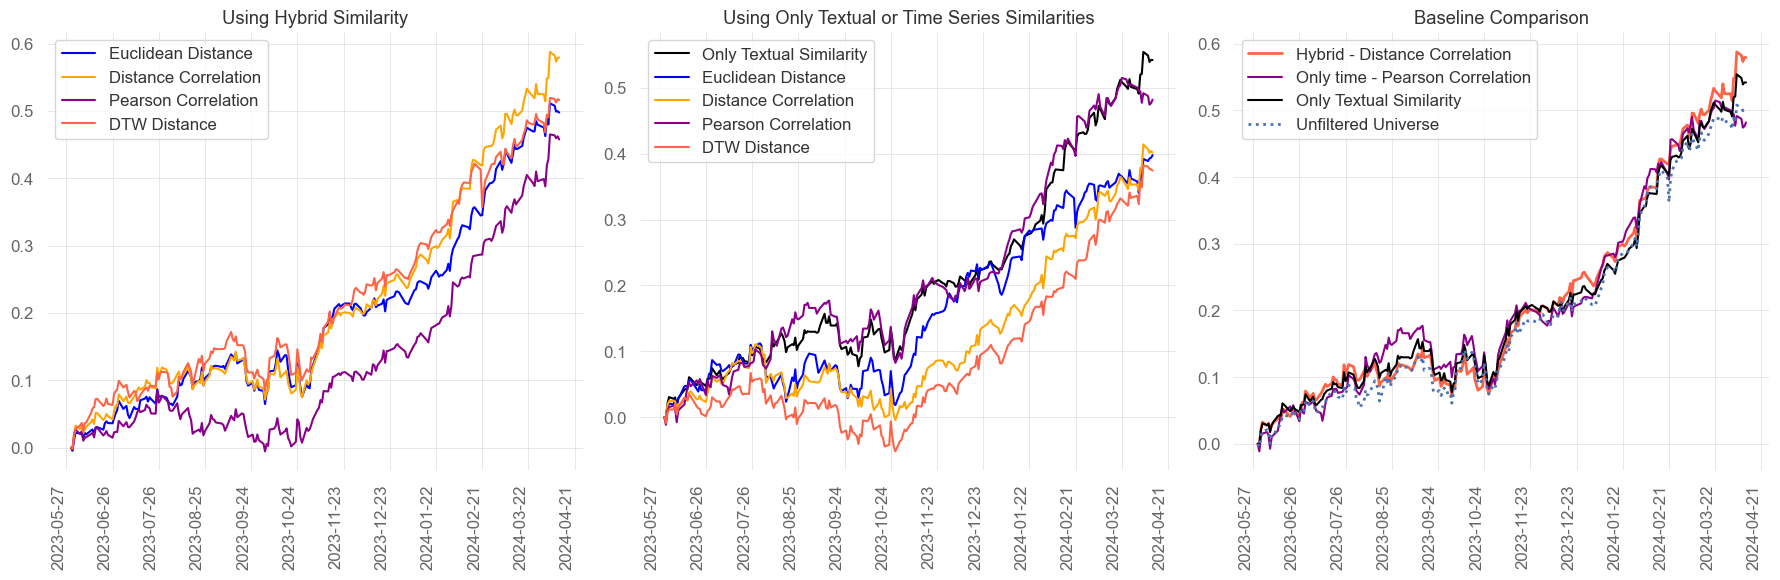

In [57]:
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Plot 1
axs[0].plot(pd.Series(np.mean(allocation_results["euclidean"][0], axis=0), index=data_index), label="Euclidean Distance", color="blue")
axs[0].plot(pd.Series(np.mean(allocation_results["dist_corr"][0], axis=0), index=data_index), label="Distance Correlation", color="orange")
axs[0].plot(pd.Series(np.mean(allocation_results["pearson"][0], axis=0), index=data_index), label="Pearson Correlation", color="darkmagenta")
axs[0].plot(pd.Series(np.mean(allocation_results["dtw"][0], axis=0), index=data_index), label="DTW Distance", color="tomato")
axs[0].set_title("Using Hybrid Similarity")

axs[0].legend()

# Plot 2
axs[1].plot(data_index, pd.Series(np.mean(allocation_results["euclidean"][2], axis=0), index=data_index), label="Only Textual Similarity", color="black")
axs[1].plot(pd.Series(np.mean(allocation_results["euclidean"][3], axis=0), index=data_index), label="Euclidean Distance", color="blue")
axs[1].plot(pd.Series(np.mean(allocation_results["dist_corr"][3], axis=0), index=data_index), label="Distance Correlation", color="orange")
axs[1].plot(pd.Series(np.mean(allocation_results["pearson"][3], axis=0), index=data_index), label="Pearson Correlation", color="darkmagenta")
axs[1].plot(pd.Series(np.mean(allocation_results["dtw"][3], axis=0), index=data_index), label="DTW Distance", color="tomato")
axs[1].set_title("Using Only Textual or Time Series Similarities")
axs[1].legend()

# Plot 3
axs[2].plot(pd.Series(np.mean(allocation_results["dist_corr"][0], axis=0), index=data_index), label="Hybrid - Distance Correlation", linewidth=2, color="tomato")
axs[2].plot(pd.Series(np.mean(allocation_results["pearson"][3], axis=0), index=data_index), label="Only time - Pearson Correlation", color="darkmagenta")
axs[2].plot(pd.Series(np.mean(allocation_results["euclidean"][2], axis=0), index=data_index), label="Only Textual Similarity", color="black")
axs[2].plot(pd.Series(mean_variance_return[1], index=data_index), label="Unfiltered Universe", linestyle="dotted", linewidth=2)
# axs[2].plot(one_n_allocation, label="1/N Allocation", linestyle="--", color="green")
axs[2].legend()
axs[2].set_title("Baseline Comparison")

for ax in axs:
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=30))  # Adjust the interval as needed
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.setp(ax.get_xticklabels(), rotation=90, ha="right")
    
plt.tight_layout()
plt.savefig('allocation_results_only_median.png')
plt.show()

In [64]:
pd.Series(np.mean(allocation_results["pearson"][3], axis=0), index=data_index).tail()

2024-04-05    0.491574
2024-04-08    0.487362
2024-04-09    0.474232
2024-04-10    0.476372
2024-04-11    0.481837
dtype: float64

In [58]:
'''
with open("allocation_results.pkl", 'wb') as file:
    pickle.dump(allocation_results, file)
'''

In [51]:
with open("allocation_results.pkl", 'rb') as file:
    allocation_results = pickle.load(file)

In [16]:
def portfolio_metrics(cum_sum, index_list):
    allocation = copy.deepcopy(pd.DataFrame(cum_sum))
    allocation.index = pd.to_datetime(index_list)
    allocation = cum_sum.pct_change()
    allocation = pd.DataFrame(allocation, columns=["return"]).dropna(inplace=False)
    allocation = allocation.replace([np.inf, -np.inf], 0, inplace=False)
    
    avg_return = qs.stats.avg_return(allocation, prepare_returns=False).item()
    sharpe = qs.stats.sharpe(allocation).item()
    max_dd = qs.stats.max_drawdown(cum_sum)
    value_at_risk = qs.stats.value_at_risk(allocation)[0]
    win_loss = qs.stats.win_loss_ratio(allocation, prepare_returns=False).item()
    
    return {"avg_return": avg_return, "sharpe":sharpe, "max_dd":max_dd, "value_at_risk":value_at_risk, "win_loss_ratio": win_loss}

In [26]:
metricbycombination = {}
for sim_metric in list(allocation_results.keys()):
    metricbycombination[sim_metric] = {}
    for combination_id in list(allocation_results[sim_metric].keys())[1:]: # ilk key path 
        metrics = [[], [], [], [], []]
        for i in range(1):
            metric_result = portfolio_metrics(pd.Series(allocation_results[sim_metric][combination_id][i]), data_index)
            print(sim_metric, combination_id, round(metric_result["sharpe"], 5))
            metrics[0].append(metric_result["avg_return"])
            metrics[1].append(metric_result["sharpe"])
            metrics[2].append(metric_result["max_dd"])
            metrics[3].append(metric_result["value_at_risk"])
            metrics[4].append(metric_result["win_loss_ratio"])
            
        avg_metrics = np.array(metrics).mean(axis=1)
        metricbycombination[sim_metric][combination_id] = avg_metrics

euclidean 0 0.97083
euclidean 2 -0.47017
euclidean 3 -0.67724
pearson 0 1.17234
pearson 2 -0.47017
pearson 3 -1.26484
dist_corr 0 1.21866
dist_corr 2 -0.47017
dist_corr 3 2.0048
dtw 0 1.71248
dtw 2 -0.47017
dtw 3 1.05379


In [94]:
pd.DataFrame(metricbycombination["euclidean"], 
             index=["avg_return", "sharpe", "max_dd", "value_at_risk", "win_loss_ratio"])

,0,2,3
avg_return,0.008584,0.199379,0.018497
sharpe,0.492704,1.196251,1.037550
max_dd,-0.004634,0.000000,-0.007232
value_at_risk,-0.444299,-4.133536,-0.444963
win_loss_ratio,0.851467,6.709297,0.933306


In [88]:
pd.DataFrame(metricbycombination["dtw"], 
             index=["avg_return", "sharpe", "max_dd", "value_at_risk", "win_loss_ratio"])

,0,2,3
avg_return,-0.037608,0.199379,-0.585146
sharpe,-0.694265,1.196251,-1.390354
max_dd,-0.001535,0.000000,-0.542616
value_at_risk,-1.445371,-4.133536,-11.521258
win_loss_ratio,0.358008,6.709297,0.211940


In [89]:
pd.DataFrame(metricbycombination["dist_corr"], 
             index=["avg_return", "sharpe", "max_dd", "value_at_risk", "win_loss_ratio"])

,0,2,3
avg_return,-0.013889,0.199379,0.771797
sharpe,-0.396993,1.196251,1.272594
max_dd,-0.002905,0.000000,-0.100655
value_at_risk,-0.923163,-4.133536,-14.994927
win_loss_ratio,0.537877,6.709297,4.052793


In [90]:
pd.DataFrame(metricbycombination["pearson"], 
             index=["avg_return", "sharpe", "max_dd", "value_at_risk", "win_loss_ratio"])

,0,2,3
avg_return,0.073906,0.199379,0.022116
sharpe,1.638167,1.196251,1.073992
max_dd,-0.003708,0.000000,-0.007867
value_at_risk,-1.099033,-4.133536,-0.513202
win_loss_ratio,1.723938,6.709297,1.227208


In [135]:
pd.DataFrame(portfolio_metrics(one_n_allocation, data_index), 
             index=["one/N"],
             columns=["sharpe", "max_dd", "value_at_risk", "win_loss_ratio"])

,sharpe,max_dd,value_at_risk,win_loss_ratio
one/N,1.068854,-0.146584,-16.961945,5.313464


In [ ]:
pd.DataFrame(portfolio_metrics(one_n_allocation, data_index), 
             index=["one/N"],
             columns=["sharpe", "max_dd", "value_at_risk", "win_loss_ratio"])

In [91]:
pd.DataFrame(portfolio_metrics(pd.Series(mean_variance_return[1]), data_index), 
             index=["unfiltered"],
             columns=["avg_return", "sharpe", "max_dd", "value_at_risk", "win_loss_ratio"])

,avg_return,sharpe,max_dd,value_at_risk,win_loss_ratio
unfiltered,0.088314,1.07018,-0.004691,-2.056983,2.065333
